# Сборный проект - 1

<b>Задание:</b> провести исследовательский анализ базы данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах,  выявить определяющие успешность игры закономерности.

<b>Описание данных:</b>
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB


## Первичный анализ данных

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Загружаем датасет

data = pd.read_csv('/datasets/games.csv')

In [3]:
# Изучаем общую информацию

data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
4394,Transformers: Revenge of the Fallen (Wii & PS2...,DS,2009.0,Action,0.26,0.14,0.00,0.04,NaN,NaN,NaN
12089,Bionicle Heroes,X360,2006.0,Shooter,0.05,0.01,0.00,0.01,59.0,5.9,E10+
3960,Picross DS,DS,2007.0,Puzzle,0.17,0.02,0.30,0.02,83.0,8.7,E
6844,Front Line,2600,1981.0,Action,0.22,0.01,0.00,0.00,NaN,NaN,NaN
1063,WCW vs. nWo: World Tour,N64,1997.0,Fighting,1.37,0.28,0.03,0.02,NaN,NaN,NaN


In [4]:
# Посмотрим на структуру таблицы

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# Посмотрим на распределение столбцов, в которых содержатся только числа

data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Первоначальный анализ данных показывает, что больше всего пропусков в столбцах, связанных с рейтингом. Возможно, основная причина в том, что рейтинги для самых свежих игр (за 2016 год) ещё не успели сформироваться, а для старых игр некому было их формировать. К тому же столбцы с количеством проданных копий содержат слишком много нулевых значений.

## Подготовка данных

### Анализ названий

In [6]:
# Приводим столбцы к нижнему регистру

data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [7]:
# Посмотрим какие платформы используются при анализе

data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [8]:
# Посмотрим какие существуют рейтинги

data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

<b>Аббревиатуры, используемые для обозначения рейтинга:</b>

- EC - early childhood
- E - everyone
- E10+ - everyone 10 and older
- T - teen
- M-Mature
- AO - adults only 18+
- RP - reiting pending

In [9]:
# Посмотрим на игры без имени

data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


### Обработка пропусков

In [10]:
# У двух игр отсутсвует наименование, избавимся о них и скинем индексы

data.dropna(subset=['name'], inplace=True)
data.reset_index(drop=True,inplace=True)

In [11]:
# Удостоверимся что датафрейм уменьшился только на 2 строки

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [12]:
#У 269 игр нет года реализации. Посмотрим на них

data[data['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Всего пропущено 269 значений в годах релиза. Восстановить данные точно не представляется возможным, пропусков немного, так что оставим все, как есть.

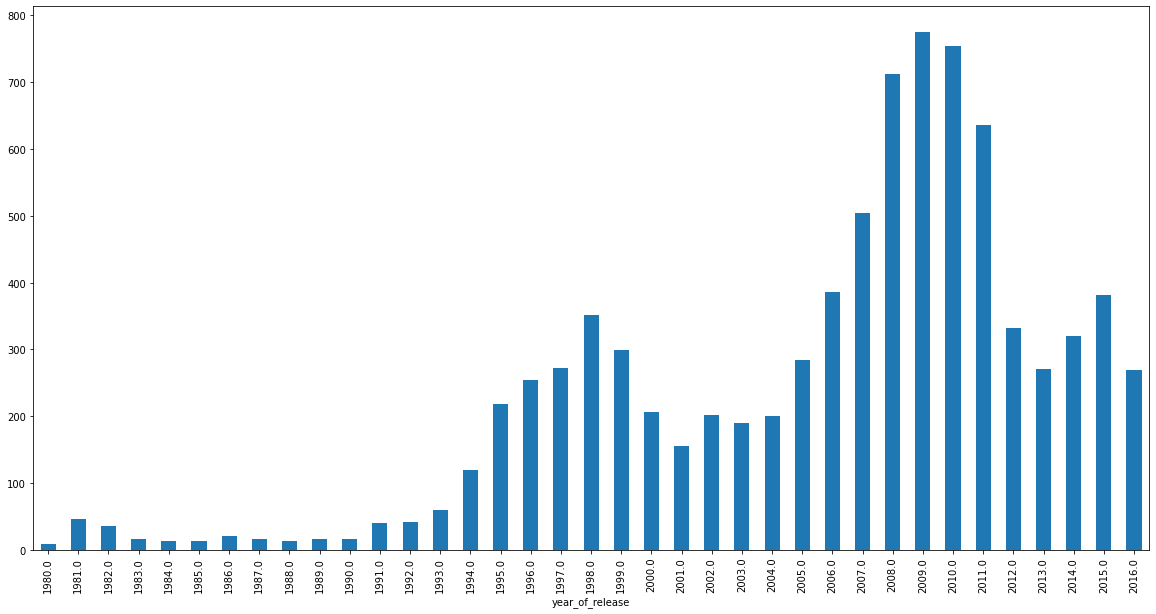

In [13]:
# Количество игр с пропущенными оценками по годам

data[data['critic_score'].isnull()].groupby(
    'year_of_release').count()['name'].plot(kind='bar', figsize=(20,10))

#plt.savefig('test.png', format='png', dpi=300)

plt.show()

In [14]:
# Заменим tbd (to be determined) на -1

data.loc[(data['user_score'] == 'tbd') | (data['user_score'].isna()), 'user_score'] = -1

# Приведём к целым числам

data['user_score'] = data['user_score'].astype('float')

In [15]:
# Некоторые игры выпускались на различные платформы в один год (или в соседний), 
# поэтому сгруппируем релевантные данные по имени и заполним пропуски 
grouped_data_by_name = data.pivot_table(index='name', aggfunc=['median'])
grouped_data_by_name

median                             \
                             critic_score eu_sales jp_sales na_sales   
name                                                                   
 Beyblade Burst                       NaN    0.000     0.03    0.000   
 Fire Emblem Fates                    NaN    0.230     0.52    0.810   
 Frozen: Olaf's Quest                 NaN    0.265     0.00    0.240   
 Haikyu!! Cross Team Match!           NaN    0.000     0.04    0.000   
 Tales of Xillia 2                   71.0    0.120     0.45    0.200   
...                                   ...      ...      ...      ...   
thinkSMART: Chess for Kids            NaN    0.000     0.00    0.010   
uDraw Studio                         71.0    0.570     0.00    1.650   
uDraw Studio: Instant Artist         54.0    0.050     0.00    0.035   
wwe Smackdown vs. Raw 2006            NaN    1.020     0.00    1.570   
¡Shin Chan Flipa en colores!          NaN    0.000     0.14    0.000   

                                                                     
                             other_sales user_score year_of_release  
name                                                                 
 Beyblade Burst                    0.000      -1.00          2016.0  
 Fire Emblem Fates                 0.110      -1.00          2015.0  
 Frozen: Olaf's Quest              0.045      -1.00          2013.0  
 Haikyu!! Cross Team Match!        0.000      -1.00          2016.0  
 Tales of Xillia 2                 0.070       7.90          2012.0  
...                                  ...        ...             ...  
thinkSMART: Chess for Kids         0.000      -1.00          2011.0  
uDraw Studio                       0.200      -1.00          2010.0  
uDraw Studio: Instant Artist       0.010       2.35          2011.0  
wwe Smackdown vs. Raw 2006         0.410      -1.00             NaN  
¡Shin Chan Flipa en colores!       0.000      -1.00          2007.0  

[11559 rows x 7 columns]

In [16]:
grouped_data_by_name.set_axis(['critic_score', 
                               'eu_sales', 
                               'jp_sales',
                               'na_sales',
                               'other_sales',
                               'user_score',
                               'year_of_release'], axis=1, inplace=True)
data_filled = pd.merge(data, grouped_data_by_name,
                       left_on='name', right_index=True,
                       how='left', suffixes=("", '_grouped'))
data_filled[data_filled['year_of_release'].isnull()].head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_grouped,eu_sales_grouped,jp_sales_grouped,na_sales_grouped,other_sales_grouped,user_score_grouped,year_of_release_grouped
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,93.0,0.09,0.0,0.710,0.030,8.00,2003.0
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,82.5,0.25,0.0,0.145,0.025,7.15,2003.0
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,75.0,0.44,0.0,0.720,0.290,7.90,2008.0
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,-1.0,NaN,NaN,1.02,0.0,1.570,0.410,-1.00,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,-1.0,NaN,NaN,0.03,0.0,0.105,0.000,-1.00,1999.0


In [17]:
def set_another_years(row):
    if pd.isnull(row['year_of_release']):
        return row['year_of_release_grouped']
    return row['year_of_release']

In [18]:
data_filled['year_of_release'] = data_filled.apply(set_another_years, axis=1)

In [19]:
data_filled['year_of_release'].fillna(1970, inplace=True)

In [20]:
# Удалим использованный столбец
del data_filled['year_of_release_grouped']

In [21]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  16713 non-null  object 
 1   platform              16713 non-null  object 
 2   year_of_release       16713 non-null  float64
 3   genre                 16713 non-null  object 
 4   na_sales              16713 non-null  float64
 5   eu_sales              16713 non-null  float64
 6   jp_sales              16713 non-null  float64
 7   other_sales           16713 non-null  float64
 8   critic_score          8137 non-null   float64
 9   user_score            16713 non-null  float64
 10  rating                9949 non-null   object 
 11  critic_score_grouped  9098 non-null   float64
 12  eu_sales_grouped      16713 non-null  float64
 13  jp_sales_grouped      16713 non-null  float64
 14  na_sales_grouped      16713 non-null  float64
 15  other_sales_grouped

In [22]:
# Пустые значения изменим на -1
data_filled['user_score'].fillna(-1, inplace=True)
data_filled['critic_score'].fillna(-1, inplace=True)

In [23]:
# Преобразуйте данные в нужные типы.
data_filled['year_of_release'] = data_filled['year_of_release'].astype('int')
data_filled.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_grouped,eu_sales_grouped,jp_sales_grouped,na_sales_grouped,other_sales_grouped,user_score_grouped
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,76.0,28.96,3.77,41.36,8.450,8.0
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN,NaN,2.44,3.48,16.24,0.495,-1.0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,82.0,12.76,3.79,15.68,3.290,8.3
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,80.0,10.93,3.28,15.61,2.950,8.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN,NaN,8.89,10.22,11.27,1.000,-1.0


In [24]:
# Посмотрим, как с годами изменялось соотношение между играми с обзорами и без них
for_analysis = data_filled.groupby('year_of_release').count()['name']
for_analysis = for_analysis.reset_index()

In [25]:
data_with_absence = data_filled.query(
    'critic_score == -1.0 or user_score == -1.0 or user_score == -2'
    ).groupby('year_of_release').count()['name']
data_with_absence = data_with_absence.reset_index()

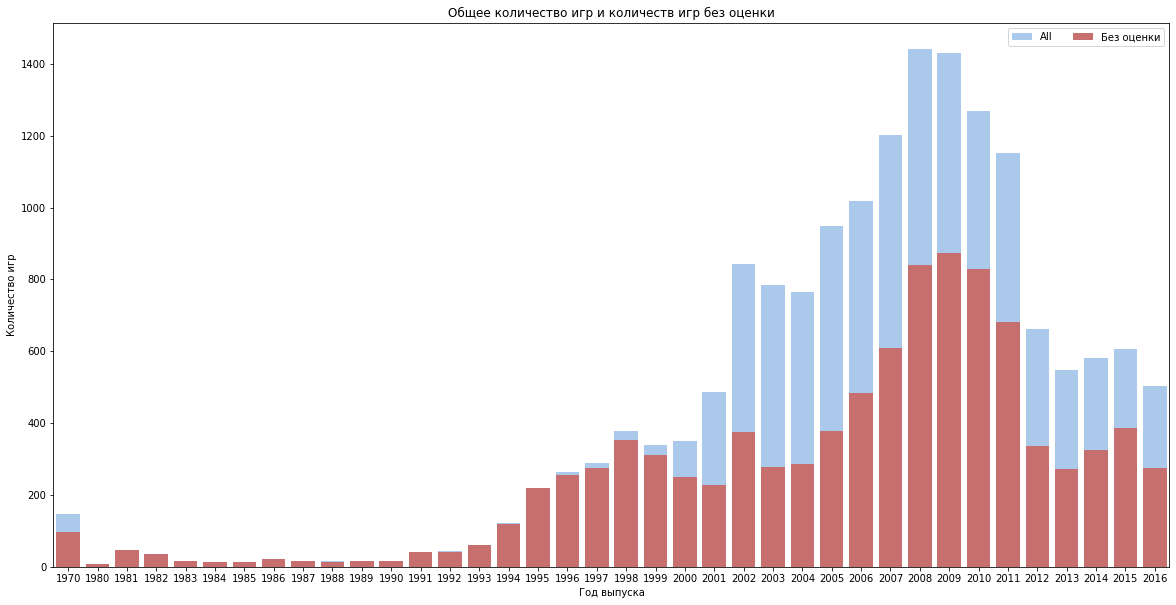

In [26]:
f, ax = plt.subplots(figsize=(20,10))

sns.set_color_codes('pastel')
sns.barplot(x='year_of_release', y='name', data=for_analysis,
           label='All', color='b'
           ).set_title('Общее количество игр и количеств игр без оценки')

sns.set_color_codes('muted')
sns.barplot(x='year_of_release', y='name', data=data_with_absence,
            label='Без оценки', color='r')

ax.legend(ncol=2, loc="best", frameon=True)
ax.set(ylabel='Количество игр',
       xlabel='Год выпуска')

plt.show()

На первичном этапе было необходимо определить наличие повторов в наименованиях игр. С помощью метода unique было обнаружено, что существует только 11560 уникальных наименования игр, что соответветствует 69% исходного набора. Следовательно, остальные 31% - это повторы. Повторы обусловлены тем, что игра выходит на разные платформ

В столбце name обнаружилось 2 пропуска, так как это игры от 1993 года, общее количество проданных копий не велико (2.39 и 0.03) и столбцы для них с жанром и отзывами пустые, их можно сбросить, на общий анализ они не повлияют. Возможная причина появления этой ошибки - специфичные для платформы игры (1993 год), о которых почти ничего не известно, но на момент обращения к сайту с информацией об играх в источнике была информация о продажах некоторых игр без имени. Также это могли быть это наборы игр (99 игр в одном).
year_of_release - 269 пропусков - 21 запись можно заполнить следующим образом, в названии игры указан год её выпуска + 1. Также у некоторых игр, выпущенных на разные платформы, отсутствуют значения в данном столбце. Их можно заполнить медианами по сгруппированным по названиям играм (+109 заполнных строк). Остальные записи заполним 1970 годом, чтобы их можно было потом использовать для анализа, но при этом они не портили картину.
critic_score и user_score - тоже попытаемся заполнить медианными значениями (удалось востановить 961 и 429 пропущенных значения соответственно). В остальных установим -1. В столбце user_score были значения tbd их мы заменили на -1 (to be determined)
Основная причина пропусков в столбцах - это ошибка в работе парсера интернет страниц. Возможно, доступ к странице с информацией об игре имеет следующий формат: url_сайта/тип_платформы/имя_игры. Но в наименовании игры также могла быть информация об платформе, для которой выпускалась игра, и, соответственно, доступ по автоматически сгенерированному url получал ошибку 404, потому что следовало искапть по игре, например, Minecraft: Switch edition, а не просто Minecraft. Также url мог выбрасывать некоторые символы (например, знак имперсанта) или заменить их на аналогичные, например вместо black ops 3 использовать black-ops-iii. 
Также существует ещё одна проблема в данных. Для старых игр очень часто отсутствуют отзывы и оценки. Возможно, сайт начал работу в более поздний период, чем начали появляться игры и, как следствие, отзывы не успевали писаться для старых игр, которые к моменту появления сайта уже исчезли из продаж (может даже консоли для этих игр исчезли к этому году). Также из графика видно, что в 2002 произошёл бурный рост объёмов производства в компьютерных играх (прирост почти в 2 раза), но при этом у людей появились консоли и пк, и они захотели поделиться своим мнением об играх (об этом свидетельствует уменьшение количества игр без отзывов с 98 по 2001 годы). В последующие годы игровая индустрия выпускает всё больше игр с привязкой к отдельным консолям, и, как следствие, игр, у которых нет отзывов становится всё больше. После 2012 года происходит переломный момент, на рынок приходят консоли нового поколения, объём ежегодно выпускаемых игр уменьшается, и, как следствие, появляется меньше пропусков в оценках игр.

## Исследовательский анализ данных

### Анализ количества игр, выпускавшихся в разные годы

In [27]:
time_release = data.groupby('year_of_release')['name'].count().reset_index()
time_release.columns = ['year', 'quantity']
time_release

,year,quantity
0,1980.0,9
1,1981.0,46
2,1982.0,36
3,1983.0,17
4,1984.0,14
5,1985.0,14
6,1986.0,21
7,1987.0,16
8,1988.0,15
9,1989.0,17


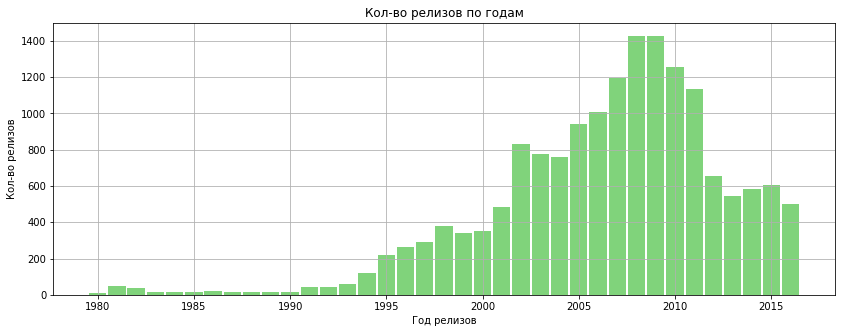

In [28]:
plt.figure(figsize=(14, 5))
plt.bar(time_release['year'], time_release['quantity'], label='Кол-во релизов за год', color='g', alpha=0.85, width=0.9)
plt.xlabel('Год релизов')
plt.ylabel('Кол-во релизов')
plt.grid()
plt.title(f'Кол-во релизов по годам')
# plt.legend()
plt.show();

Вывод: Период до 1994 года характеризуется малой активностью. Хорошо видно, что важный период в релизах игр наступает в 1994 году - и после него начинается бум - компьютерные игры захватывают мир. В 2010 наступает переломный момент и уже в 2012 релизы падают в 2 раза и до 2016 держатся примерно на одно уровне

### Анализ продаж по платформам

In [29]:
# Просуммируем все продажи в отдельный столбец
data_filled['all_sales'] = (data_filled['na_sales'] +
                            data_filled['eu_sales'] + 
                            data_filled['jp_sales'] + 
                            data_filled['other_sales'])

plf = data_filled.groupby('platform')['all_sales'].sum().sort_values().reset_index()
plf

,platform,all_sales
0,PCFX,0.03
1,GG,0.04
2,3DO,0.10
3,TG16,0.16
4,WS,1.42
5,NG,1.44
6,SCD,1.86
7,DC,15.95
8,GEN,28.35
9,SAT,33.59


Возьмем около 10 платформ с наибольшими объемами продаж. Построим по ним распределение продаж по годам

In [30]:
popular_platforms = plf.loc[17:30, 'platform'].values
popular_platforms

array(['NES', 'GB', 'XB', '3DS', 'PC', 'PSP', 'PS4', 'GBA', 'PS', 'DS',
       'Wii', 'PS3', 'X360', 'PS2'], dtype=object)

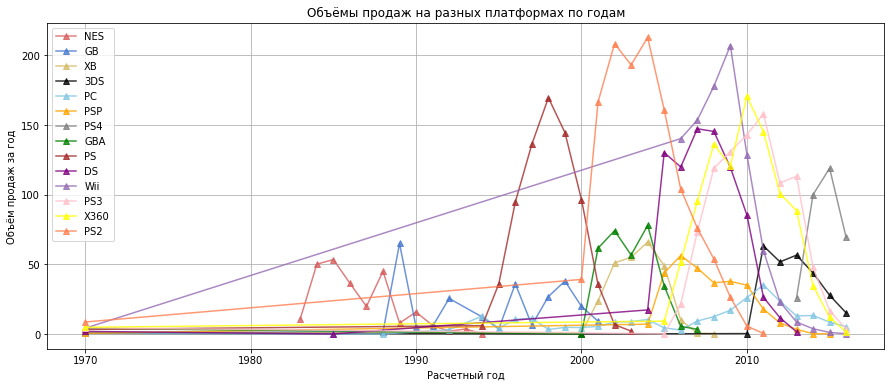

In [31]:
color = ['r','b','y','black','c','orange','grey','green','brown','purple','m','pink','yellow','coral','darkcyan','dimgray','lime']

plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Объёмы продаж на разных платформах по годам')

mean_year_life = 0
for i in range(0,len(popular_platforms)):
    platform  = data_filled.query('platform == @popular_platforms[@i]').groupby('year_of_release')['all_sales'].sum()
    mean_year_life += platform.count()

    platform.plot(x=platform.index, y=platform.values, style='-^', color=color[i], \
                  label=popular_platforms[i], alpha=0.8, grid=True);
plt.xlabel('Расчетный год')    
plt.ylabel('Объём продаж за год')
plt.legend()
plt.show();

In [32]:
#посчитаем средний срок жизни платформы

mean_year_life/len(popular_platforms)

12.285714285714286

Вывод: Расчетное значение 12,3 года, а из графика видно, что срок активного существования платформ 9-10 лет(если не обращать внимания на минимальные значения по краям), и распределение продаж идет близко к нормальному распределению,Поэтому будем считать,что средний срок жизни платформы - 10-12 лет. Можно выделить из списка платформ - "PC" (компьютеры), они хоть и не в топах по выручке, но актуальны во все времена. Также надо отметить,что платформа "DS" просуществовала очень долго - до 2013 года.

### Прогноз на 2017 год 

В условиях задачи стоит следующее: Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Для прогноза возьмем данные за 2 года, с 2014.



In [33]:
platform2017 = data_filled.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum').\
    query('year_of_release>2013').fillna(0).reset_index()
platform2017['year_of_release'] = platform2017['year_of_release'].astype('Int64')

for column in platform2017.columns:
    if platform2017[column].sum()==0:
        platform2017.drop(column, axis=1,inplace=True)

display(platform2017)

platform,year_of_release,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
1,2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2,2016,15.14,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


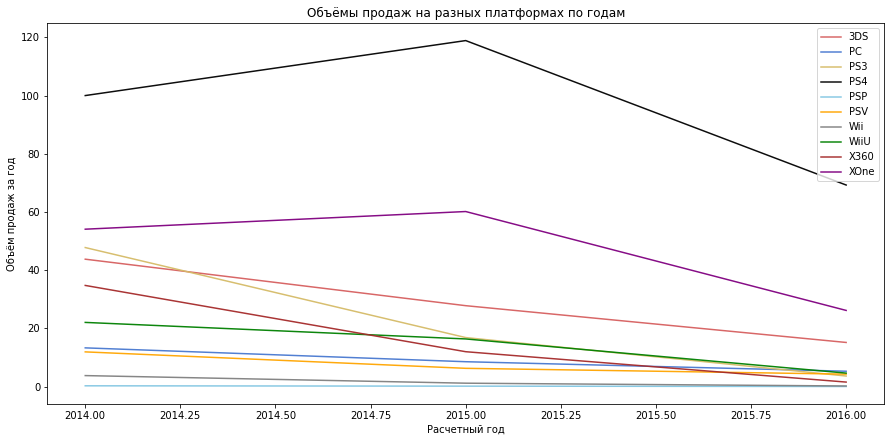

In [34]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.title('Объёмы продаж на разных платформах по годам')

i=0
for column in platform2017.columns[1:]:
    plt.plot(platform2017['year_of_release'].to_list(), platform2017[column].to_list(), label=column, color=color[i], alpha=0.95);
    i+=1 

plt.grid()
plt.xlabel('Расчетный год')    
plt.ylabel('Объём продаж за год')
plt.legend()
plt.show();

Видно , что многие популярные платформы, такие как: Wii, PS3, X360, PSP, - прошли свой цикл развития 10-12 лет, и как раз в районе текущего 2016 года завершающий аккорд (другие платформы PS2, DS, GBA, XB, закончились еще раньше) - во все эти платформы вкладываться не стоит, их развитие закончилось.

Но есть две платформы PS4 и XOne, которые появились относительно недавно (в 2013 году) и уже завоевали потребителя в 2014 и 2015: наблюдается рост, а в 2016 был спад; их жизненный цикл еше не дошёл даже до середины, поэтому будет логично воспользоваться спадом и развивать эти, на данный момент, самые перспективные платформы.

Еще есть другие 3 платформы, которые появились пораньше PSV(слабое развитие) в 2011 / WiiU в 2012 / 3DS в 2011 и на данные момент на середине своего цикла развития, поэтому вложения в эти платформы должны быть умеренными

Также надо обратить внимание платформу PC , которая существует уже очень долго и стабильно, она актуальна во все времена (но в небольших объемах).

In [35]:
#Создадим список из топ-5 потенциально прибыльных платформ top5_2017 на 2017 год
#Список популярных с 2005 года top2005

top5_2017 = ['PS4', 'XOne', 'WiiU', 'PSV', '3DS']

top2005 = data_filled.query('year_of_release>=2005').groupby('platform')['all_sales'].sum().sort_values(ascending=False).reset_index().head(10)
top2005

,platform,all_sales
0,X360,966.61
1,PS3,935.19
2,Wii,903.31
3,DS,786.99
4,PS2,427.39
5,PS4,314.14
6,PSP,286.51
7,3DS,258.51
8,PC,170.84
9,XOne,159.32


### Глобальные продажи игр в разбивке по платформам

In [36]:
#Возьмем 8 самых продаваемых платформ (в остальных продажи довольно низки)

top8 = top2005.head(8)
top8

,platform,all_sales
0,X360,966.61
1,PS3,935.19
2,Wii,903.31
3,DS,786.99
4,PS2,427.39
5,PS4,314.14
6,PSP,286.51
7,3DS,258.51


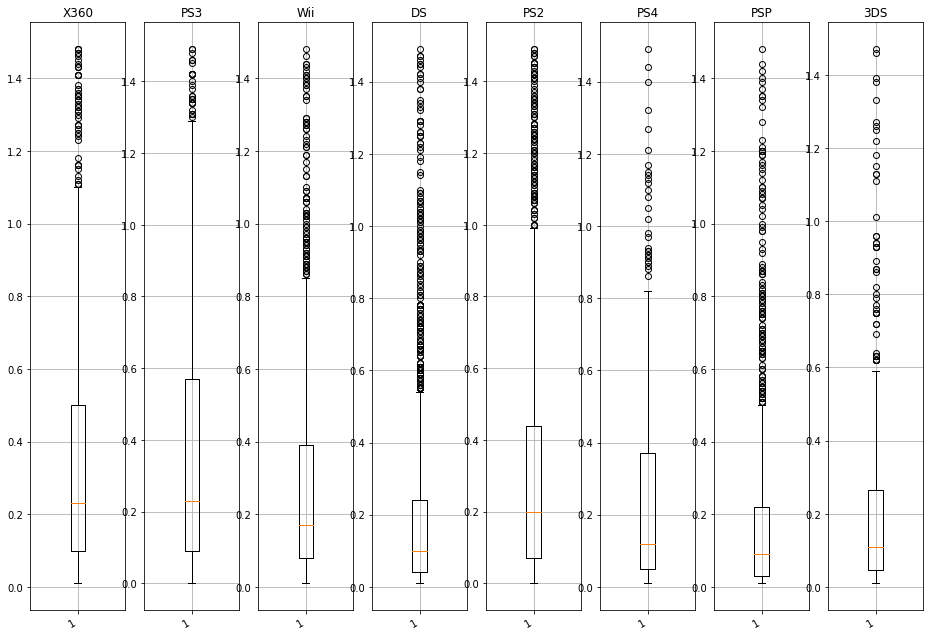

In [37]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=1, ncols=8, figsize=(16, 12))
fig.autofmt_xdate();

p = {ax1:'X360', ax2:'PS3', ax3:'Wii', ax4:'DS', ax5:'PS2', ax6:'PS4', ax7:'PSP', ax8:'3DS'}
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    sales = data_filled.query('platform==@p[@ax] and all_sales<1.5')['all_sales']
    ax.boxplot(sales)
    ax.grid()
    ax.set_title(p[ax])

fig.autofmt_xdate()

Продажи на популярных платформах схожи. Медианные значения продаж у четырех X360, PS3, Wii, PS2 находятся близко к уровню 0,2, а в других 4 к уровню 0,1. На платформах 3DS,DS и PSP большая часть проданых игр лежит до значения в 0,5-0,6, на платформах PS4, Wii и PS2 до 0,85-1, а в лидерах X360 до 1,1 и в PS3 до 1,3млн.

### Продажи внутри одной популярной платформы и отзывы и cоотношение с другими платформами 

#### Влияние Продажи-Отзывы на одной популярной платформе

In [38]:
top8

,platform,all_sales
0,X360,966.61
1,PS3,935.19
2,Wii,903.31
3,DS,786.99
4,PS2,427.39
5,PS4,314.14
6,PSP,286.51
7,3DS,258.51


In [39]:
#Выберем для примера популярную платформу "X360"

one_pl = data_filled.query('platform=="X360"')[['all_sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)
one_pl

,all_sales,critic_score,user_score
0,21.82,61.0,6.3
1,16.27,97.0,8.1
2,14.73,88.0,3.4
3,14.62,87.0,6.3
4,13.68,83.0,4.8
...,...,...,...
1257,0.01,49.0,2.1
1258,0.01,-1.0,-1.0
1259,0.01,-1.0,-1.0
1260,0.01,-1.0,5.1


In [40]:
one_pl.corr()

,all_sales,critic_score,user_score
all_sales,1.000000,0.310367,0.207274
critic_score,0.310367,1.000000,0.788668
user_score,0.207274,0.788668,1.000000


Коэффициент Зависимости Продаж от отзывов критиков = 0.3103667897677197


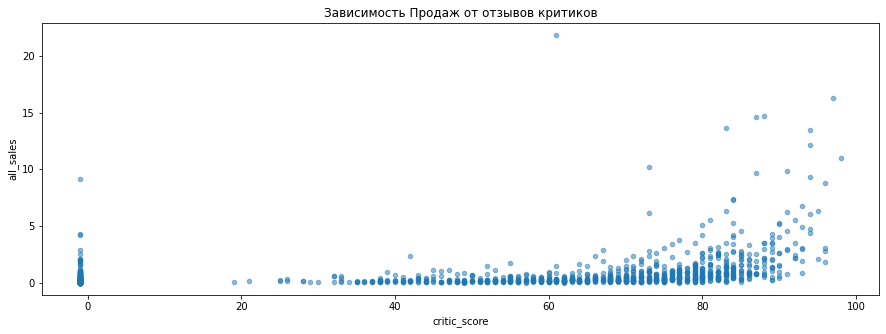

In [41]:
print('Коэффициент Зависимости Продаж от отзывов критиков =' , one_pl['all_sales'].corr(one_pl['critic_score']))
one_pl.plot(x='critic_score',y='all_sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость Продаж от отзывов критиков');


Коэффициент Зависимости Продаж от отзывов пользователей = 0.20727444033968054


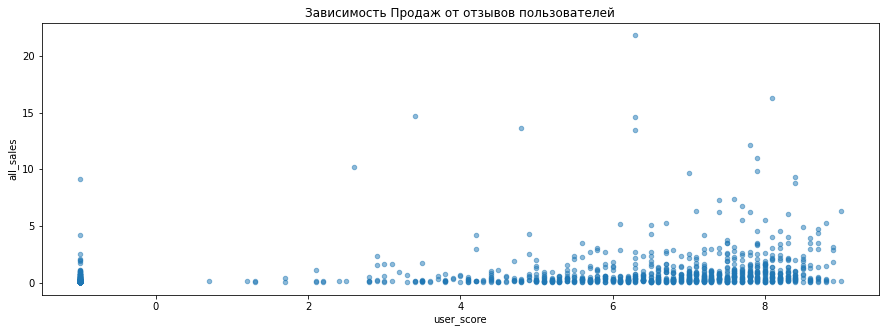

In [42]:
print('Коэффициент Зависимости Продаж от отзывов пользователей =' , one_pl['all_sales'].corr(one_pl['user_score']))
one_pl.plot(x='user_score',y='all_sales',kind='scatter',figsize=(15,5), alpha=0.5)
plt.title('Зависимость Продаж от отзывов пользователей');

По платформе X360: Отзывы критиков важны, хотя зависимость продаж от них находится на уровне средней на границе со слабой(коэффициент 0,39); зависимость здесь прямопропорциональная - чем выше оценка, тем выше продажи. 
И зависимость продаж от отзывов пользователей, как выясняется, слабая, но ближе к средней, также она прямопропорциональная(хотя коэффициент значительно меньше - 0,115). В общем зависимости схожи.

#### Соотношение с другими платформами

In [43]:
top8

,platform,all_sales
0,X360,966.61
1,PS3,935.19
2,Wii,903.31
3,DS,786.99
4,PS2,427.39
5,PS4,314.14
6,PSP,286.51
7,3DS,258.51


In [44]:
#Создадим словарь sale_score с продажами и отзывами

sale_score = {}
for p in top8['platform']:
    sale_score[p] = data_filled.query('platform==@p')[['all_sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)

In [45]:
# Запишем в таблицу corr8 корелляции продаж с отзывами по топ8 платформам

i=0
corr8 = pd.DataFrame(columns=['platform','crit_sale','user_sale'])
for pl_name in sale_score.keys():
    corr8.loc[i, 'platform'] = pl_name
    corr8.loc[i, 'crit_sale'] = sale_score[pl_name]['all_sales'].corr(sale_score[pl_name]['critic_score'])
    corr8.loc[i, 'user_sale'] = sale_score[pl_name]['all_sales'].corr(sale_score[pl_name]['user_score'])
    i+=1

In [46]:
corr8

,platform,crit_sale,user_sale
0,X360,0.310367,0.207274
1,PS3,0.353793,0.272669
2,Wii,0.188942,0.183879
3,DS,0.158524,0.186076
4,PS2,0.299548,0.259366
5,PS4,0.226526,0.115961
6,PSP,0.334408,0.347164
7,3DS,0.166598,0.145973


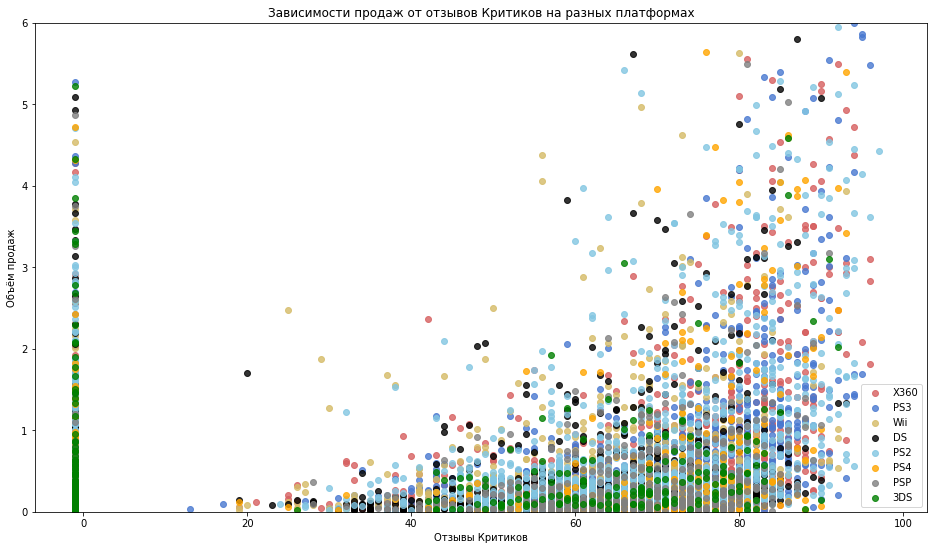

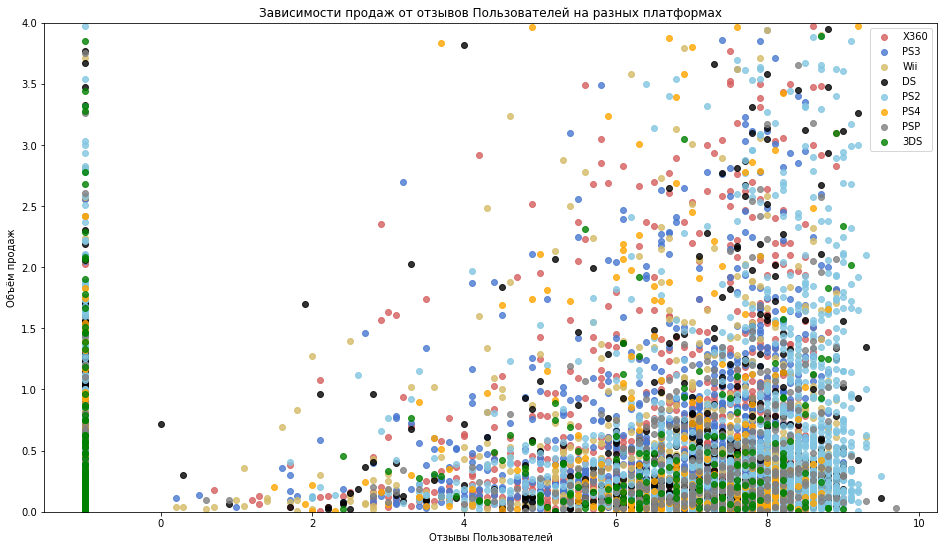

In [47]:
# Теперь нарисуем зависимости на графиках
# Зависимости продаж от отзывов Критиков

plt.figure(figsize=(16, 9))
plt.grid()
plt.title('Зависимости продаж от отзывов Критиков на разных платформах')
i=0
for p in corr8['platform']:
    xc = sale_score[p]['critic_score'].to_list()
    yc = sale_score[p]['all_sales'].to_list()
    plt.scatter(xc, yc, label=p, color=color[i], alpha=0.8);
    i+=1 
plt.ylim(0,6)
plt.grid()
plt.xlabel('Отзывы Критиков')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show();

# Зависимости продаж от отзывов Пользователей
plt.figure(figsize=(16, 9))
plt.grid()
plt.title('Зависимости продаж от отзывов Пользователей на разных платформах')
i=0
for p in corr8['platform']:
    xc = sale_score[p]['user_score'].to_list()
    yc = sale_score[p]['all_sales'].to_list()
    plt.scatter(xc, yc, label=p, color=color[i], alpha=0.8);
    i+=1 
plt.ylim(0,4)
plt.grid()
plt.xlabel('Отзывы Пользователей')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show();

Схожие тенденции имеют место почти для всех платформ. Зависимость продаж пропорциональная- от отзывов критиков слабая (но ближе к средней), а от отзывов пользователей значительно слабее, чем критиков, во многих её почти нет(очень слабая зависимость присутствует в PSP, 3DS и PS2). 
Надо сказать об отдельных зависимостях: в PS4 - Пользователи не влияют на продажи, В Wii и DS зависимость Критиков очень слабая.

### Распределение игр по жанрам 

In [48]:
# Сгруппируем по жанру

genres = data.groupby('genre')['name'].count().sort_values(ascending=False)
genres

genre
Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: name, dtype: int64

In [49]:
# Количество продаж по жанрам

genre_sales = data_filled.groupby('genre')['all_sales'].sum().sort_values(ascending=False)
genre_sales

genre
Action          1744.17
Sports          1331.27
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: all_sales, dtype: float64

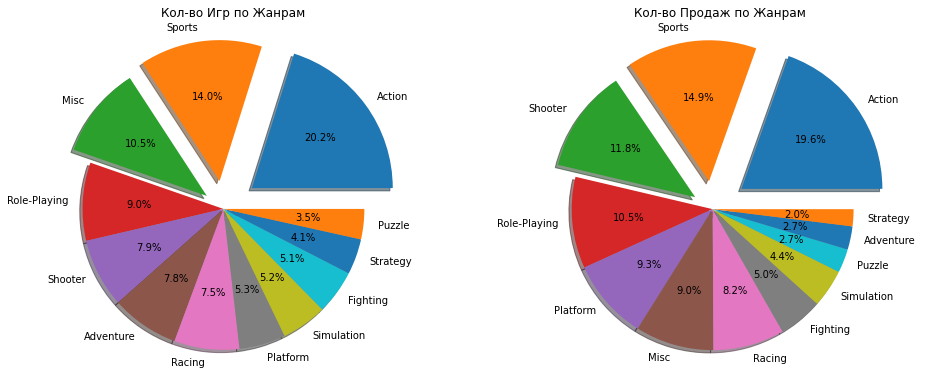

In [50]:
# Визуализируем данные в графиках

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig.autofmt_xdate();


labels1 = genres.index
sizes1 = genres.values

labels2 = genre_sales.index
sizes2 = genre_sales.values
explode = (0.25, 0.2, 0.15, 0,0,0,0,0,0,0,0,0)
ax1.set_title('Кол-во Игр по Жанрам')
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%',
        shadow=True, explode=explode,startangle=0)  
ax1.axis('equal')  

ax2.set_title('Кол-во Продаж по Жанрам')
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%',
        shadow=True, explode=explode,startangle=0) 
ax2.axis('equal')

plt.show()



При анализе объёма игр по годам (по суммарным тиражам и по количеству уникальных игр) видно, что наиболее продуктивным с точки зрения игроделов можно считать 2008-2010 год. Именно в эти годы индустрия выпускает наибольшее количество игр в год и имеет максимальные продажи. Для анализа продаж по платформам будем анализировать только топ-10 платформ по продажам, которые определяются из соответствующего графика на интервале 3 сигма. Для данного интервала медианное срок работы платформы - 10 лет. Медиана использована потому, что ПК не является платформой, которая может устареть, а также потому, среди фаворитов по количеству продаж есть PS4, которая только начинает свой жизненный цикл в качестве игровой платформы (по крайней мере на 2016 год она именно этим и занималась).
Список неактуальных платформ на 2016 год:

- Xbox360
- wii
- DS
- PS3

Растут продажи следующих платформ:

PS4
Платформа nintendo 3ds является специфичной платформой (это портативная консоль) и срок работы у неё короче, пик продаж был в 2015, но они до сих пор полузуются популярностью

Продажи XboxONE были на пике в 2015 и сейчас идут на спад, но в 2017 они будут ещё актуальны Интетрес пользователей к ПК хоть и небольшой, но не падает как у консолей.

Портативные консоли PSP, PS Vita и WiiU также находястся на закате жизненного цикла или продажи по ним совсем отсуствуют, но при этом игры для PSV в 2017 будут ещё актуальны в 2017 году. Эра портативных консолей подошла к концу.


Таким образом лидирующие позиции занимают:

- PS4
- 3DS
- Xbox One
- PC
- WiiU
Общее распределение игр по жанрам - в тройку лидеров входят Action(20,2%), Sports(14%) и Sports(10,5%); аутсайдеры здесь Puzzle(3,5%), Strategy(4,1%) и Fighting(5,1%)

В продажах по жанрам в лидерах опять Action(19,6%), Sports(14,9%), но на 3 месте уже Shooter(11,8); аутсайдеры здесь Strategy(2%), Puzzle(2,7%) как и в первом графике, но 3 место у Adventure(2,7%).
Можно отметить, что продажи лидера Action и аутсайдера Strategy отличаются в 10 раз.

Пользователи всегда предпочитали поиграть в Action игры (вроде GTA, Batman, Assassin's Creed). До 2011 года люди любили играть в музыкальные игры, там где надо двигаться в ритм музыке и аналогичные, но потом интерес к этой категории игр угас. Со спортивными играми аналогичная ситуация. Шутеры же в свою очередь неизменно пользуются интересом у пользователей. Интерес к остальным категориям игр с годами только уменьшается.

## Портрет пользователя для каждого региона

Определяем для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5)
- Самые популярные жанры (топ-5)
- Влияет ли рейтинг ESRB на продажи

### Анализируем популярность платформ

In [51]:
# Самые популярные платформы (топ-5)
popul_5platf_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    popul_5platf_dict[region] = data.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
popul_5platf_dict

{'na_sales': platform
 X360    602.47
 PS2     583.84
 Wii     496.90
 PS3     393.49
 DS      382.40
 Name: na_sales, dtype: float64,
 'eu_sales': platform
 PS2     339.29
 PS3     330.29
 X360    270.76
 Wii     262.21
 PS      213.61
 Name: eu_sales, dtype: float64,
 'jp_sales': platform
 DS      175.57
 PS      139.82
 PS2     139.20
 SNES    116.55
 3DS     100.67
 Name: jp_sales, dtype: float64}

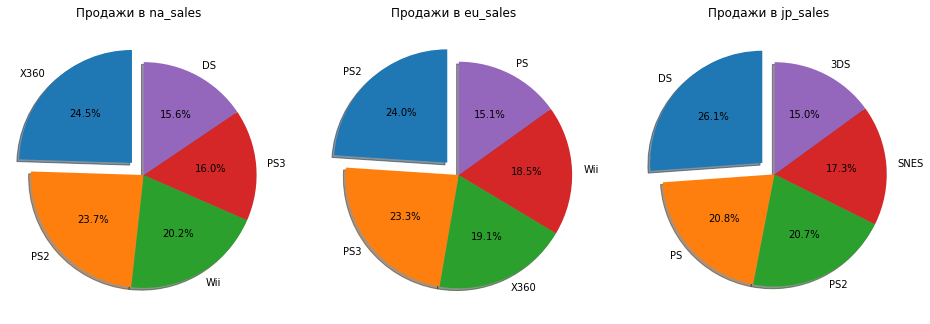

In [52]:
# Теперь отразим это все на графиках

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']
explode = (0.15, 0, 0, 0, 0)

for i in [0,1,2]:
    labels = popul_5platf_dict[region[i]].index
    sizes = popul_5platf_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {region[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,startangle=90) 
    ax.axis('equal')  

plt.show()

Лидеры продаж во всех регионах разные: Америка - X360, Европа - PS2 и Япония - DS. В Америке и Европе пользуются в основном одними и теми же 4 платформами - X360, PS2, Wii, PS3, исключение в Америке любят больше DS,а в Европе PS. В Японии совсем другая картина: тут более популярны платформы DS, SNES и 3DS. Надо отметить, что платформа PS2 очень популярна во всех регионах.

### Анализируем популярность жанров

In [53]:
# Запишем в словарь popul_5genre_dict данные по продажам топ-5 жанрам в 3 регионах 

popul_5genre_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    popul_5genre_dict[region] = data.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
popul_5genre_dict

{'na_sales': genre
 Action      879.01
 Sports      684.43
 Shooter     592.24
 Platform    445.50
 Misc        407.27
 Name: na_sales, dtype: float64,
 'eu_sales': genre
 Action     519.13
 Sports     376.79
 Shooter    317.34
 Racing     236.51
 Misc       212.74
 Name: eu_sales, dtype: float64,
 'jp_sales': genre
 Role-Playing    355.41
 Action          161.43
 Sports          135.54
 Platform        130.83
 Misc            108.11
 Name: jp_sales, dtype: float64}

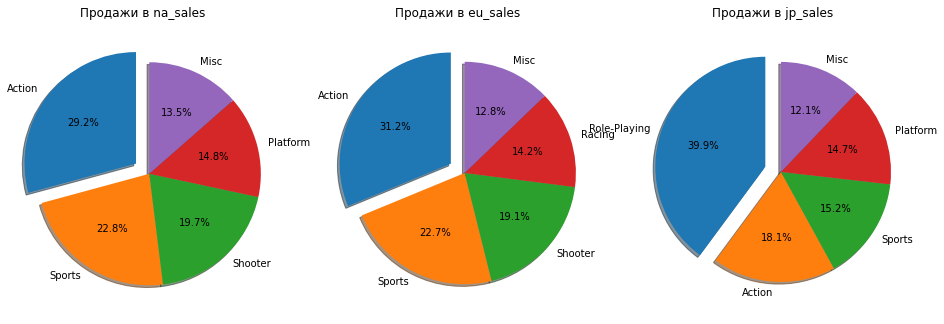

In [54]:
# Теперь отразим это все на графиках

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']
explode = (0.15, 0, 0, 0, 0)

for i in [0,1,2]:
    labels = popul_5genre_dict[region[i]].index
    sizes = popul_5genre_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {region[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,startangle=90) 
    ax.axis('equal')  

plt.show()

В Америке и Европе совпадают топ-3 жанра: Action, Sports и Shoter, а также совпадает на 5 месте Misc(даже и в Японии тоже на 5 месте); различия на 4 месте в Америке Platform, а в Европе Racing. Наверно это можно объяснить общей культурой и менталитетом и конечно же языками - английский, испанский, французский, итальянский. В Японии же другая культура и язык совсем другой (больше 95% японцев в Японии говорят только на японском) поэтому и лидирует жанр Role-Playing, хотя тоже очень популярны Action и Sports, присутствует жанр Platform, как и в Америке на 4 месте.

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [55]:
esrb_sale = data.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().sort_values(by='na_sales', \
                                                                                       ascending=False).reset_index()

esrb_sale

/tmp/ipykernel_154/4234181208.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  esrb_sale = data.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().sort_values(by='na_sales', \


,rating,na_sales,eu_sales,jp_sales
0,E,1292.99,710.25,198.11
1,T,759.75,427.03,151.40
2,M,748.48,483.97,64.24
3,E10+,353.32,188.52,40.20
4,K-A,2.56,0.27,1.46
5,EC,1.53,0.11,0.00
6,AO,1.26,0.61,0.00
7,RP,0.00,0.08,0.00


Справка:
https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board
Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

«E» («Everyone») — «Для всех»
«T» («Teen») — «Подросткам»
«M» («Mature») — «Для взрослых»
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»

«EC»(«K-A» - в ранних версиях с 1994-1997 годы) («Early childhood») — «Для детей младшего возраста»
«AO» («Adults Only 18+») — «Только для взрослых»
«RP» («Rating Pending») — «Рейтинг ожидается»

Существует (по нашей таблице) 4 основных рейтинга: «E»,«T»,«M» и «E10+» (4 другие очень не популярны, поэтому учитывать их в анализе нет смысла).Влияние рейтинга на продажи в разных регионах почти одинаково. На первом месте «E» и далее «T»,«M» и «E10+», исключение Европа, где продажи с рейтингом «M» на 13% больше, чем с «T». Да и доли этих рейтингов в своем регионе навскидку тоже примерно одинаковы.

Как видно из графиков, люди в Северной Америке и в Европе используют платформы одного поколения, они лишь немного отличаются в процентном соотношении (В Америке предпочитают Xbox360, а в Европе PS3). Ситуация в остальном мире аналогична Европе и Америке, за тем лишь исключением, что вместо портативной консоли DS геймеры предпочитают PS2.

Люди во всём мире (кроме Японии) отдают предпочтение стационарным консолям перед портативными. В Японии ситуация несколько иная. Там люди предпочитают играть на 3DS и DS игнорируя при этом Xbox 360 (возможно он там тоже запрещён, как и PS4). Ещё одним доказательством, что японцы предпочитают портативные консоли, заключается в том, что только у японских геймеров популярны PSP.

Во всех странах люди любят поиграть в Action, музыкальные игры и в спортивные игры (японцы чуть меньше чем остальной мир, любят игры в жанре Sports). В японии люди очень редко играют в шутеры, отдавая предпочтение играм в жанре Adventure Role-Playing. Люди в Европе вместо Role-Playing выбирают Racing. В категорию Action игр преимущественно попадают самые топовые игры, поэтому неудивительно, что данный жанр нравится людям из всех стран. Игры в стиле RPG больше всего приглянулись японцам, а вот в Европе пользователи к ним равнодушны. Это объясняется тем, что RPG чаще выходят на портотивных консолях и, как было показано на графиках выше, именно в Японии их и предпочитают.

Различий в продажах игр в различных регионах практически нет. Только в Японии игры для тинейджеров покупаются чаще, чем игры для врослых. Корреляции между рейтингом игры и суммарными продажами в регионе не обнаружена.

## Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы
- Средние пользовательские рейтинги жанров Action и Sports отличаются

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковы

In [56]:
#Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковы; 
#Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

#Сформируем массивы (списки) для обоих платформ

XOne = data.query(' platform == "XOne" ')['user_score'].dropna().to_list()
PC = data.query(' platform == "PC" ')['user_score'].dropna().to_list()

#Подсчитаем дисперсии, чтобы определиться с параметром equal_var

print('Дисперсия XOne =', np.var(XOne), '// Дисперсия PC =', \
      np.var(PC))

Дисперсия XOne = 12.36705305774558 // Дисперсия PC = 12.611255022789654


Дисперсии отличаются (около 24%), поэтому возьмем equal_var=False

Так как нам не нужны сверхточные значения, то укажем критический уровень статистической значимости 5% alpha = 0.05

По заданию надо проверить гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Так как H₀ всегда формулируется так, чтобы использовать знак равенства, то нулевую гипотезу сформулируем также (как по заданию): Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; альтернативная гипотеза H₁ тогда будет такая - Средние пользовательские рейтинги платформ Xbox One и PC различны.

In [57]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(XOne, PC, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0010304276753605973
Отвергаем нулевую гипотезу


Соответственно средние пользовательские рейтинги жанров Xbox One и PC отличаются.

### Средние пользовательские рейтинги жанров Action и Sports отличаются

In [58]:
# Сформируем массивы (списки) для обоих жанров (так как в столбце 'user_score' много пропусков удалим строки, где они присутствуют)

Action = data.query(' genre == "Action" ')['user_score'].dropna().to_list()
Sports = data.query(' genre == "Sports" ')['user_score'].dropna().to_list()

#Подсчитаем дисперсии, чтобы определиться с параметром equal_var

print('Дисперсия Action =', np.var(Action), '// Дисперсия Sports =', \
      np.var(Sports))

Дисперсия Action = 17.198931599296255 // Дисперсия Sports = 17.00584700016542


Дисперсии отличаются не сильно (около 21%), поэтому возьмем equal_var=True

Так как нам не нужны сверхточные значения, то укажем критический уровень статистической значимости 5% alpha = 0.05

По заданию надо проверить гипотезу: Средние пользовательские рейтинги жанров Action и Sports отличаются.

Так как H₀ всегда формулируется так, чтобы использовать знак равенства то нулевую гипотезу сформулируем так: Средние пользовательские рейтинги жанров Action и Sports равны; альтернативная гипотеза H₁ тогда будет такая - Средние пользовательские рейтинги жанров Action и Sports отличаются (как по заданию).

In [59]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(Action, Sports, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2025568367391132e-08
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу - это значит, что Гипотеза №2 отвергнута, а Средние пользовательские рейтинги жанров Action и Sports одинаковы.

## Вывод

При первоначальном анализе было обнаружено большое количество пропусков в столбцах с рейнигом, годом издания игры, оценками критиков и оценками пользователей. В работе используются различные подходы к заполнению недостающих значений с целью включению в выборку для анализа как можно большего количества релевантной информации. 

Для заполнения пропусков использовалась средние значения, сгруппированные по играм, так как одни и те же игры выходят на несколько платформ и заполнение пропусков медианами является допустимым решением, так как ни год реализации, ни оценки критиков существенно не отличаются у одноимённых игр. Для заполнения года реализации также использовались регулярные выражения для вычленения года выпуска игры из её наименования. Как правило, игра выходит на год раньше, чем указано в её имени

В различные года на рынке доминировали различные платформы, но наилучшие продажи за всё время показала PS2. Как было выяснено из анализа распределения продаж игр на различных платформах по годам, медианное время жизни платформы составляет 10 лет, однако из графиков видно, что портативные консоли живут меньше (примерно в 2 раза).

В различные годы пользователи предпочитали различные платформы, но в период с 2007 по 2016 пользователей в большей степени интересовали Wii (2007-2009), Xbox 360 (2010), PS3 (2011-2013), PS4(2014-2016). При анализе продаж на различные платформы было выявлено, что хоть разброс значений у различных платформ и сильно отличается (игровые индустрии выпускают хиты для отдельных платформ) средние значения для всех платформ почти одинаковые: 250 тыс для стационарных консолей и 125 тыс для портативных и ПК

При анализе корреляции между оценками и продажами было выяснено, что оценки пользователей вообще не коррелируют с продажами, а оценки критиков лишь на 0.39, что также является недостаточным для составления рекламной кампании.

Из года в год самыми популярными жанрами остаются игры в жанрах Action, Shooter и RPG.

Портрет пользователей для различных регионов имеет преимущественно одинаковый вид для всего мира. Однако в Японии люди склонны играть на портативных консолях и поэтому для них характерным жанром игр является RPG и именно японцы предпочитают игры для Teen в большей степени, по сравнению с остальным миром.

При анализе гипотез было выяснено, что оценки пользователей для платформ Xbox One и PC одинаковы, но при этом оценки для разных игровых жанров у пользователей отличаются.